# Plotting record temperatures for New Orleans over the period 2005-2015
### [Aashita Kesarwani](http://www.aashitak.com/about/)

National Oceanic and Atmospheric Administration(NOAA) dataset has been stored in the file `data_temperatures_nola.csv`. The data contains daily climate records coming from the 12 stations of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily)  near **New Orleans, Louisiana, United States** over the period from Jan 01, 2005 to Dec 31, 2015. 

The code is written for Python 3.6. Though it runs for Python 2 versions, the visuals, especially the colors that are taken from the Google Material Design color palette, are less appealing.

First we read the data from the file `data_temperatures_nola.csv` into the pandas dataframe `df`:

In [1]:
import pandas as pd
import numpy as np
filename = "data_temperatures_nola.csv"
df = pd.read_csv(filename)

Each row in the datafile corresponds to a single observation. There are four columns in the datafile as follows:
* **ID** : station identification code
* **Date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **Element** : indicator of element type
    * TMAX : Maximum temperature 
    * TMIN : Minimum temperature 
* **Data_Value** : data value for element (tenths of degrees C)

The temperatures are given at tenths of degrees celsius and are taken from multiple locations in New Orleans at multiple 
times of the day everyday from Jan 01, 2005 to Dec 31, 2015.


In [2]:
df.head(5)

ID        Date Element  Data_Value
0  USW00053917  2005-07-06    TMAX         306
1  USW00012884  2011-10-05    TMIN         211
2  USC00168941  2014-09-16    TMIN         233
3  USC00166676  2012-07-20    TMIN         239
4  USC00168941  2009-04-22    TMAX         283

The dataframe `df` is prepared to extract the data in desired format:

In [3]:
df.loc[:,'Data_Value'] *= 0.1 # Dividing all temperature entries by 10 to convert them to degree celsius
df['Date'] = pd.to_datetime(df['Date']) # Changing the dtype of the date to pandas datetime 

# Setting up the sorted multi-index consisting of month and days so as to help grouping rows later for each 
# day of the year
df['Day'] = pd.DatetimeIndex(df['Date']).day 
df['Month'] = pd.DatetimeIndex(df['Date']).month 
df = df.set_index(['Month','Day']) 
df.sort_index(inplace = True)

# Discarding all the entries for 29th Feb of any year; only 365 days of the year are considered
selected_df = df.loc[2,29] 
df = df[~df.index.isin(selected_df.index)] 

In [4]:
# Splitting dataframes into two - one for 2005-2014 and another for 2015
df['Year'] = pd.DatetimeIndex(df['Date']).year
df_2015 = df[df['Year'] == 2015] 
df = df[df['Year'] != 2015] 

# Creating two dataframes for 2005-2014 - one each for max and min
max_temp_df = df[df['Element'] == 'TMAX'] 
min_temp_df = df[df['Element'] == 'TMIN'] 

# The following gives pandas series with 365 entries corresponding to the max/min temperatures 
# over the decade 2005-2014 for each day of the year
max_temp = max_temp_df.groupby(level = ['Month', 'Day'])['Data_Value'].max()  
min_temp = min_temp_df.groupby(level = ['Month', 'Day'])['Data_Value'].min()

# Creating two dataframes for 2015 - one each for max and min
max_temp_df_2015 = df_2015[df_2015['Element'] == 'TMAX']
min_temp_df_2015 = df_2015[df_2015['Element'] == 'TMIN'] 

# The following gives dataframes with 365 rows corresponding to the max/min temperatures for each day of 
# the year 2015 and two columns in total viz one for temperature values and another for dates stored 
# as the pandas datatime object  
max_temp_df_2015 = max_temp_df_2015.groupby(level = ['Month', 'Day']).max()[['Data_Value', 'Date']]
min_temp_df_2015 = min_temp_df_2015.groupby(level = ['Month', 'Day']).min()[['Data_Value', 'Date']]

Plotting graphs for record high and low temperatures for each day of the year over the period 2005-2014 using ```matplotlib```:

<IPython.core.display.Javascript object>


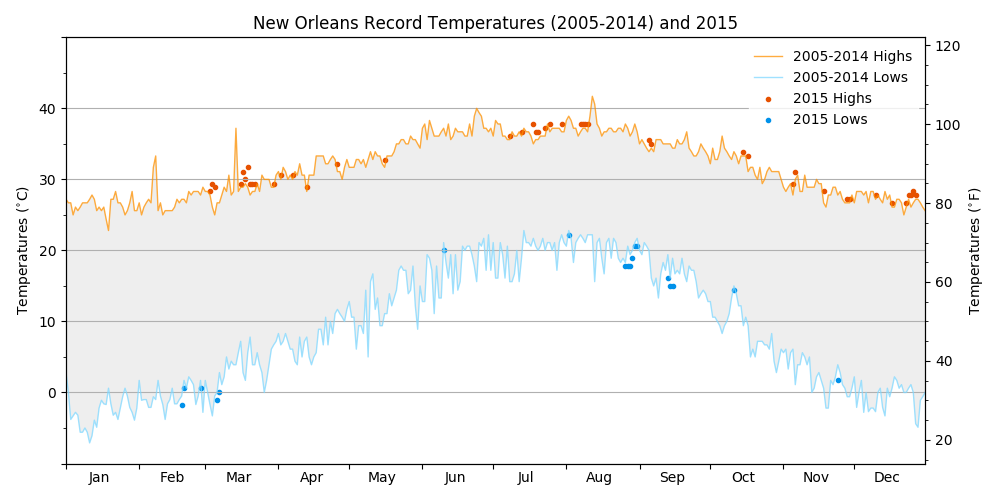

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
% matplotlib notebook

# Need 365 days array for plotting in pandas datetime format; year does not matter so taken 2015 
# for convenience
date_range = df_2015['Date'].unique() 

# Creating figure and an axis
fig, ax = plt.subplots( nrows=1, ncols=1, figsize = (10,5) ) 
ax.set_title('New Orleans Record Temperatures (2005-2014) and 2015') # Setting the title
ax.yaxis.grid() # Setting up the horizontal grid lines in the background

# Plotting graphs and filling in between region
# Google Material Design color palette (https://material.io/guidelines/style/color.html) is used below: 
plt.plot(date_range, max_temp.values, '#FF9100', linewidth = 1, alpha=0.75, label = '2005-2014 Highs')
plt.plot(date_range, min_temp.values, '#80D8FF', linewidth = 1, alpha=0.75, label = '2005-2014 Lows') 
plt.fill_between(date_range, min_temp, max_temp, facecolor='#EEEEEE')

###### The matplotlib notebook magic keeps the graph in interactive mode and hence the code below will keep on updating the graph as it is run.

Adding semi-transparent legend with no border:

In [6]:
plt.legend(loc = 1).get_frame().set_edgecolor('white') 

# Labels for the legends of the scatter plots below
my_label_max = "2015 Highs"
my_label_min = "2015 Lows"

Scattering record breaking temperatures from the year 2015 as red and blue dots over the graph:

In [7]:
for idx, rows in max_temp_df_2015.iterrows():
    if rows['Data_Value'] > max_temp.loc[idx]:
        plt.scatter(rows['Date'], rows['Data_Value'], c = '#E65100', marker = '.', label = my_label_max)
        my_label_max = "_nolegend_" # To avoid duplicate labels in the legend
for idx, rows in min_temp_df_2015.iterrows():
    if rows['Data_Value'] < min_temp.loc[idx]:
        plt.scatter(rows['Date'], rows['Data_Value'], c = '#0091EA', marker = '.', label = my_label_min)
        my_label_min = "_nolegend_"
        
# Adding the labels for the max and min points to the above legend 
ax.legend(loc = 1).get_frame().set_edgecolor('white') 

This is to set up the x-axis:

In [8]:
# Setting the limits for x-axis to fit the dates perfectly
xmin, xmax = date_range[0], date_range[-1]
ax.set_xlim(xmin, xmax)

# Locating 12 positions for the 15th of each month on x-axis 
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))

# Labeling the 12 months on x-axis at the positions located above
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# Centering month labels in between the ticks and removing undesirable ticks
xticks = ax.xaxis.get_minor_ticks()
for xtick in xticks:
    xtick.tick1line.set_markersize(0)
    xtick.tick2line.set_markersize(0)
    xtick.label1.set_horizontalalignment('center')

This is to set up the left y-axis for temperatures in Celsius:

In [9]:
ax.set_ylabel('Temperatures $(^{\circ}$C)') # Set label for y-axis

# Setting the temperature limits for y-axis from -10 to 50 degrees Celsius
ymin, ymax = -10, 50
ax.set_ylim(ymin, ymax) 

yticks = ax.yaxis.get_major_ticks()
yticks[0].label1.set_visible(False) # Making 50 degrees Celsius disappear to make the graph look cleaner
yticks[1].label1.set_visible(False) # Making -10 degrees Celsius disappear to make the graph look cleaner
ax.yaxis.set_major_locator(ticker.MultipleLocator(10)) # Putting major ticks at every 10 degrees Celsius
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5)) # Putting minor ticks at every 5 degrees Celsius

This is to set up the right y-axis for temperatures in Fahrenheit:

In [10]:
ax2 = ax.twinx() # Create a twin y-axis sharing the x-axis with the previous y-axis
ax2.set_ylabel('Temperatures $(^{\circ}$F)') # Setting label for y-axis
def C_to_F(temp_c): # Celsius to Fahrenheit  
    return 9/5 *temp_c + 32
ax2.set_ylim(C_to_F(ymin), C_to_F(ymax)) # (ymin, ymax) are defined above
ax2.yaxis.set_major_locator(ticker.MultipleLocator(20)) # Putting major ticks at every 20 degrees Fahrenheit
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(5)) # Putting major ticks at every 5 degrees Fahrenheit

fig.tight_layout() # To make the graph fit perfectly in the figure window

In [ ]:
# Saving the figure to a png file; comment "% matplotlib notebook" before using this option 
# fig.savefig('foo.png', bbox_inches='tight')   
# plt.close(fig)